# Lecture 26 - Advanced Curve Fitting: Deep Neural Networks (DNN) 

## Objectives

+ to introduce Deep Neural Networks as function approximators. 
+ to set up and train DNNs in `PyTorch`.
+ to introduce Physics-informed Neural Networks (PINNs) and solve a few simple PDEs. 

## References 

+ Stanford CS231n course notes and video lectures (https://cs231n.github.io/). 

+ Physics-informed neural networks (Raissi et al, 2017) - Part I - https://arxiv.org/abs/1711.10561, Part II - https://arxiv.org/abs/1711.10566.

In [1]:
import numpy as np

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import six
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline 

## Review - generalized linear models (GLMs)

We introduced generalized linear models as parametric function approximations earlier in course. Without loss of generality, the GLM approximation of a scalar function $f : \mathcal{X} \rightarrow \mathcal{Y}$ can be expressed as:
$$
f(\mathbf{x}) = \mathbf{w}^T \phi(\mathbf{x}),
$$

where, $\phi(\mathbf{x}) = (\phi_1(\mathbf{x}), \phi_2(\mathbf{x}), \dots, \phi_M(\mathbf{x}))^T$ is a vector of basis functions and $\mathbf{w}$ is a vector of weights. The regression task is the problem of inferring the parameters $\mathbf{w}$ from a given dataset. To summarize, given a dataset of observations, $\mathcal{D}$, our goal is to estimate the conditional probability - $p(\mathbf{w}| \mathcal{D})$. By Bayes' rule, $p(\mathbf{w}| \mathcal{D}) \propto p(\mathbf{w}) p(\mathcal{D}|\mathbf{w})$. 
The simplest way to do this is to approximate $p(\mathbf{w}| \mathcal{D})$ as a delta function centered at the mode of the posterior - leading to the classic maximum a-posteriori (MAP) estimate of $\mathbf{w}$. 
If the prior is a Gaussian and the likelihood is also a Gaussian with fixed noise, the posterior over $\mathbf{w}$ and the resulting predictive distribution on new test observations can both be derived in closed form. If these requirements are not satisfied we can use Markov Chain Monte Carlo (MCMC) or Variational Inference (VI) to approximate the posterior over $\mathbf{w}$.

In theory GLMs can approximate functions of any arbitrary complexity upto any arbitrary degree of tolerance. In practice one might encounter some difficulties:

1. The choice of basis functions (what type and how many) is non-trivial. 
2. The number of basis functions required, when $\mathrm{dim}(\mathcal{X}) \gg 1$ will explode (curse of dimensionality). 
3. etc.

## Deep Neural Networks (DNNs)

Deep Neural Networks are function approximators that express information in a hierarchical or layered fashion. Mathematically, deep neural networks can be expressed as:
$$
f(\mathbf{x}) = f_L \circ f_{L-1} \circ \cdots \circ f_1( \mathbf{x}).
$$

In it's simplest setting, the layers $f_i$s are a composition of an elementwise nonlinearity with a linear transformation:
$$
f_i ( \mathbf{z} ) = \sigma_i ( \mathbf{W}_i^{T} \mathbf{z} + \mathbf{b}_i  ),
$$

where, $\mathbf{W}_i \in \mathbb{R}^{d_{z} \times  d_i}, \mathbf{b}_i \in \mathbb{R}^{d_i}$, where, $d_z = \mathrm{dim}(\mathbf{z})$, the dimensionality of the inputs to the $f_i$, $d_i$ is the dimensionality of the output from $f_i$ and $\sigma_i$ is the elementwise nonlinearity. A function with this structure is called a *fully-connected* network. 

In deep learning parlance the matrix $\mathbf{W_i}$ is referred to as a *weight* matrix, the vector $\mathbf{b}_i$ is referred to as a *bias* and the function $\sigma_i(\cdot)$ is referred to as the *activation* function. It is typical for all but last layer of a DNN to have the same activation function. 

At the final layer, the dimensionality of the output $d_L$ and the activation function at the final layer, $\sigma_L$ is dictated by constraints on the final output of the function $f$. For example:
1. If the output from $f$ is a real number with no constraints, $d_L=1$ and $\sigma_L(x) = 1$.
2. If the output from $f$ is a positive real, $d_L = 1$ and $\sigma_L(x) = \exp(x)$. 
3. If the output from $f$ is a probability mass function on $K$ categories, $d_L = K$ and $\sigma_L (x)_i = \frac{\exp(x_i)}{\sum_{j=1}^{K} \exp(x_j)}, i=1, 2, \dots, K$.
4. etc.

Different ways of constructing the compositional structure of $f$ lead to different *architectures* such as fully connected networks (shown above), *recurrent neural networks*, *convolutional neural networks*, *autoencoders*, *residual networks* etc. etc. 

###  Activation functions 

The most common activation functions include the rectified Linear Units or ReLU (and variants), sigmoid functions, hyperolic tangents, sinusoids, step functions etc. A useful way to think about activation functions is that they are analogous to the effect of covariance functions on the regularity of Gaussian process sample paths - different choices of activation functions impose different regularity conditions on the sample paths of a DNN. 

See for instance, sample paths from a 2 hidden layer NN with different activation functions.

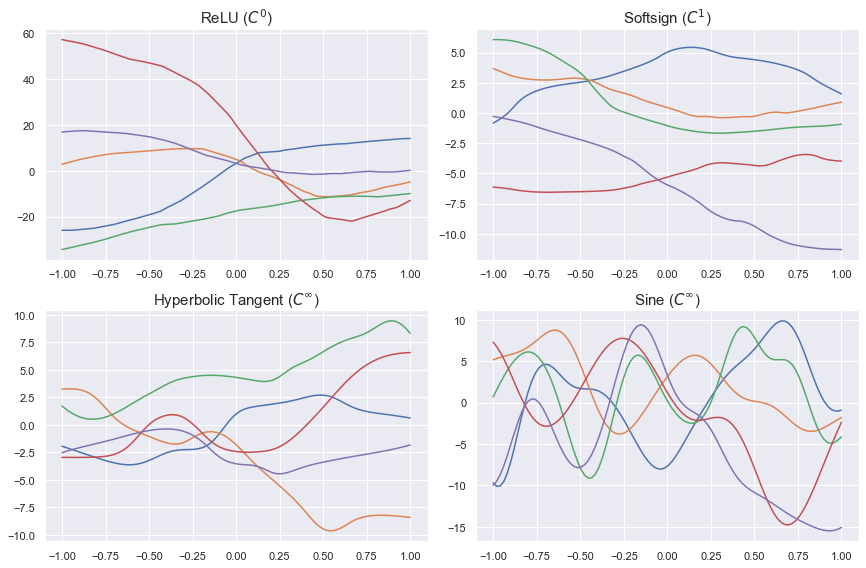

In [4]:
relu = lambda x : np.maximum(x, 0.)
softsign = lambda x : x / (1. + np.abs(x))
identity = lambda x : x

def NN(x, fn):
    D = [1, 50, 50, 1]
    Ws = [np.random.randn(D[i-1], D[i]) for i in range(1, len(D))]
    bs = [np.random.randn(D[i]) for i in range(1, len(D))]
    y = x
    for i in range(len(Ws) - 1):
        y = fn(np.dot(y, Ws[i]) + bs[i])
    y = np.dot(y, Ws[-1]) + bs[-1]
    return y

x = np.linspace(-1., 1, 100)[:, None]
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

fns = [relu, softsign, np.tanh, np.sin] 
names = ['ReLU', 'Softsign', 'Hyperbolic Tangent', 'Sine']
continuities = ['$C^0$', '$C^1$', '$C^{\infty}$', '$C^{\infty}$']
for i in range(2):
    for j in range(2):
        idx = 2*i + j
        name = names[idx]
        fn = fns[idx]
        for k in range(5):
            ax[i, j].plot(x, NN(x, fn))
        ax[i, j].set_title(name+' ('+ continuities[idx] +')', fontsize=15)
fig.tight_layout()

## Probabilistic formulation


The probabilistic formulation of DNNs follows the same approach as GLMs. We begin with a prior (say, zero-mean Gaussian with diagonal precision) on the unknown parameters (weights and biases):
$$
p(\mathbf{W}_i) = \mathcal{N}(\mathbf{W}_i | 0, \sigma_{W_i}^{2} \mathbf{I}), 
$$
and 
$$
p(\mathbf{b}_i) = \mathcal{N}(\mathbf{b}_i | 0, \sigma_{b_i}^{2} \mathbf{I}). 
$$

Denote the flattened vector of all weights and biases collectively as $\theta = (\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2, \dots)$

The structure of the data will inform our likelihood model. For the standard regression problem we get:
$$
p(\mathbf{y}_i | \theta ,\mathbf{x}_i) =  \mathcal{N} (\mathbf{y}_i | f(\mathbf{x}; \theta), \sigma^2).
$$
The data samples are assumed to be independent and identically distributed observations following the above likelihood model. 


The goal of inference is to then estimate the posterior distribution over the unknown weights and biases:
$$
p( \theta |\mathbf{y} ,  \mathbf{X})  \propto p(\theta) p(\mathbf{y} | \theta , \mathbf{X}) = p(\theta) \prod_{i=1}^{N} p(\mathbf{y}_i | \theta ,\mathbf{x}_i).
$$

Note that the mean of the likelihood, $\mathbb{E}[y_i | \mathbf{x}_i, \theta] = f(\mathbf{x}_i ; \theta)$ is a nonlinear function of $\theta$. This makes posterior inference over $\theta$ is therefore intractable in closed form. If the network has no hidden layers, $f(\mathbf{x}; \theta)$. The standard GLM is the special case of the DNN when it has no hidden layers, thereby making Bayesian inference analytically tractable.

The most common approach to inferring the parameters of a DNN is to maximize the log of the posterior, i.e., we need to solve the optimization problem:

$$
\theta^* = \underset{\theta}{\mathrm{argmax}} \log p( \theta |\mathbf{y} ,  \mathbf{X})
$$

Assuming a flat prior over the biases and a independent Gaussian prior over all the weights (i.e., all the weight components have the same prior precision, say, $\lambda$), we obtain the following optimization problem for DNN regression:

$$
\theta^* = \underset{\theta}{\mathrm{argmin}} \sum_{i=1}^{N} \frac{1}{2}(y_i - f(\mathbf{x}_i, \theta))^2   + \lambda \| \mathbf{W} \|_{2}^{2}
$$

You probably notice that this looks like the standard DNN loss function (upto a multiplicative constant) with the $L_2$ regularization over the network weights. 

In general, you will find that DNN loss functions have the structure: 
$$
\mathcal{L}(\theta; \mathbf{X}, \mathbf{y}) = \mathcal{D}(\mathbf{y}, f(\mathbf{X};\theta)) + \mathcal{R}(\theta),
$$

where, $\mathcal{D}(\mathbf{y}, f(\mathbf{X};\theta))$ is a measure of the discrepancy between the DNN predictions and the data, and $\mathcal{R}(\theta)$ is a regularization term which corresponds to a prior over the DNN parameters and imposes specific inductive biases onto the network. For instance, selecting the Laplacian, rather than Gaussian prior, over the NN weights induces sparsity (i.e. collapses many of the DNN MAP weights to zero). 

For a more robust Bayesian approach to inference in DNNs, you can resort to MCMC (most commonly performed with the NUTS algorithm) or Variational Inference (typically with a mean-field Gaussian variational posterior).

## Stochastic Gradient Descent

There is one more ingredient that allows us to scale inference over datasets with millions of observation, namely, *stochastic gradient descent* or SGD. 

SGD attempts to solve stochastic optimization problems of the form: 
$$
\theta^* = \underset{\theta}{\mathrm{argmin}} \mathbb{E}_{\xi \sim p(\xi)} [ \mathcal{L}( \theta ; \xi) ]. 
$$
where, the objective function is an expectation of a function of $\theta$ over the random variable $\xi$.
SGD is an iterative method that starts with an initial estimate of the optimization variable $\theta$, say $\theta_0$, and updates it according to the rule: 
$$
\theta_i = \theta_{i-1} - \eta_i  \frac{1}{M} \sum_{j=1}^{M}\nabla_{\theta} \mathcal{L}( \theta_{i-1} ; \xi_j),\ i=1, 2, \dots, 
$$
where, $\eta_i$ is the step-size in the $i^{th}$ iteration and $\nabla_{\theta}(\cdot)$ is the gradient wrt to $\theta$. 
The objective function is approximated with a Monte Carlo (MC) approximation. This update rule is guaranteed to converge to a local minimum of the objective function if the following conditions hold:
$$
\underset{i \rightarrow \infty}{\mathrm{lim}} \eta_i = 0, \\
\sum_{i=1}^{\infty} \eta_i = \infty, \\
\sum_{i=1}^{\infty} \eta_i^2 < \infty.
$$

In training DNNs, the data plays the role of the random variable $\xi$. Suppose we postulate that the data samples are drawn from some underlying distribution $(\mathbf{x}_i, y_i) = d_i \sim p(\mathcal{D})$. The DNN training objective function can be expressed as the expectation of a function $\mathcal{L}(\theta)$ (the discrepancy + the regularizing term) over the entire dataset:
$$
\theta^* = \underset{\theta}{\mathrm{argmin}} \mathbb{E}_{\mathcal{D} \sim p(\mathcal{D})} [ \mathcal{L}( \theta ; \mathcal{D})]. 
$$
The expectation can be approximated with an average (i.e. Monte Carlo approximation) over a small subset of the data samples, $\tilde{\mathcal{D}} = {(\mathbf{x}_i, y_i)}_{i=1}^{M} \subset \mathcal{D}$:
$$
\theta^* = \underset{\theta}{\mathrm{argmin}} \frac{1}{M} \sum_{i=1}^{M} \mathcal{L}( \theta ; \mathbf{x}_i, y_i),\ (\mathbf{x}_i, y_i)  \in \tilde{\mathcal{D}}.
$$

Thus, at each iteration of SGD, we only need to access and perform computations over a small subset $\tilde{\mathcal{D}}$ of the data instead of the full dataset $\mathcal{D}$ which contains potentially millions of data samples. In neural network parlance, the subset $\tilde{\mathcal{D}}$ is called a *mini-batch*.

To summarize, the training procedure goes as follows:

1. Initialize all the parameters of the network $\theta \leftarrow \theta_0$. 

2. For i = 1, 2, ..., :
    
    (i) Sample a subset of the dataset $\tilde{\mathcal{D}} \sim p(\mathcal{D})$. 
  
    (ii) Compute the average loss over the minibatch $L_i = \frac{1}{M} \sum_{j=1}^{M} \mathcal{L}( \theta ; \mathbf{x}_j, y_j)$.
    
    (iii) Update the weights of the network with the SGD update rule, $\theta_i  \leftarrow \theta_{i-1} - \eta_i L_i$.

3. Stop when convergence criteria is met.

In practice, vanilla SGD is rarely used due to numerical instabilities associated with it. There are many variants of SGD which apply preconditioning on the gradient updates to accelerate convergence to a local minimum. The most commonly used variant is the Adaptive Moments (ADAM) optimization method ([see here](https://arxiv.org/pdf/1412.6980.pdf)). 

## Computing gradients 

To be able to use SGD to train our DNNs we need to able to obtain gradients of the DNN wrt $\theta$. As the size and structure of the network increases, deriving gradients by hand will become extremely tedious (practically impossible). Fortunately, we need not ever have to derive gradients by hand. Software libraries such as `PyTorch` use automatic differentiation to derive the gradients. Note automatic differentiation returns *exact* gradients (in contrast to the approximation of the gradient one might obtain from finite differences). 

## Defining a network in `PyTorch`

`PyTorch` is a library for fast numerical linear algebra and statistical computations (just like `numpy`). It comes with built-in support for GPU acceleration and automatic differentiation. It also shares a high-degree of syntactic similarity with `numpy`. Along with with `tensorflow`, it is one of the two most popular frameworks for implementing deep learning methods.

`PyTorch` allows you to implement arbitrarily complex and large DNN by working with templates and utilities defined in `torch.nn`. The main class you need to know is the `torch.nn.Module` class - it serves as a convenient wrapper for defining DNNs with any arbitrary structure.
Trainable parameters in `PyTorch`  are defined as instances of `nn.Parameter` class. The `nn.Module` class registers every instance of a parameter definition inside it's `__init__` function. 

Here's a basic template to implement an $L$-layer fully connected network. 

In [3]:
class NeuralNetwork(nn.Module):
    """
    An implementation of a fully connected feed forward 
    Neural network in pytorch. 
    """
    def __init__(self, layersizes=[1, 1], 
                 activation=torch.relu,
                 final_layer_activation=None):
        """
        INPUTS:
            layersizes <list/tuple>: An iterable ordered object containing
                                 the sizes of the tensors from the
                                 input layer to the final output. 
                                 (See example below). 
            activation <callable>: A python callable through which
                                    torch backpropagation is possible.
            final_layer_activation <callable>: A python callable for 
                                    the final layer activation function.
                                    Default: None (for regression problems)
        
        EXAMPLE: 
            To define a NN with an input of size 2, 2 hidden layers of size 
            50 and 50, output of size 1, with tanh activation function: 
            >> layers = [2, 50, 50, 1]
            >> neuralnet = NeuralNet(layers, activation=torch.tanh)
            >> x = torch.randn(100, 2)   # 100 randomly sampled inputs 
            >> output = neuralnet(x)  # compute the prediction at x.
        
        Inheriting from nn.Module ensures that all
        NN layers defined within the __init__ function are captured and 
        stored in an OrderedDict object for easy accesability.
        """
        super(NeuralNetwork, self).__init__()
        self.layersizes = layersizes
        self.input_dim = self.layersizes[0]
        self.hidden_sizes = self.layersizes[1:-1]
        self.output_dim = self.layersizes[-1]
        self.activation = activation
        self.final_layer_activation = final_layer_activation
        if self.final_layer_activation is None:
            self.final_layer_activation = nn.Identity()
        self.nlayers = len(self.hidden_sizes) + 1
        self.layernames = [] ## Dictionary to store all the FC layers 
        
        # define FC layers
        for i in range(self.nlayers):
            layername = 'fc_{}'.format(i+1)
            layermodule = nn.Linear(self.layersizes[i], self.layersizes[i+1])
            self.layernames.append(layername)
            setattr(self, layername, layermodule)
        
    def forward(self, x):
        """
        Implement the forward pass of the NN. 
        """
        for i, layername in enumerate(self.layernames):
            fclayer = getattr(self, layername)
            x = fclayer(x)
            if i == self.nlayers - 1:
                x = self.final_layer_activation(x)
            else:
                x = self.activation(x)
        return x


# # sanity check 
# net = NeuralNetwork([1, 40, 40, 40, 1], torch.tanh)
# x = torch.linspace(0., 1., 100)[:, None]
# for m in net.modules():
#     print(m)

## Optimizing parameters of a network in `PyTorch`

Classes for all of the common SGD routines are implemented in `torch.optim`. To use a particular optimization method, you need to define an instance of it and initialize it with a iterable (list/tuple/generator) consisting of the parameters that need to be optimized and a starting step size (or learning rate). The list of parameters of any instance of a torch `Module` can be obtained with `module.parameters()`. 

## Example - Motor Cycle Data

Here's a demonstration of the process of setting up and training a simple fully-connected neural network. We will use the motor cycle accident dataset for this exercise. 

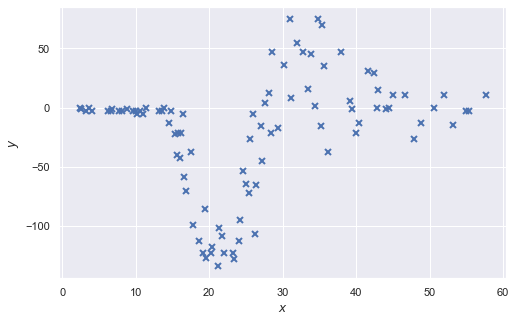

In [6]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1][:, None]
N = len(X)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [24]:
Ntrain = int(0.7*N)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, train_size=Ntrain)

# scale the data
xscaler = StandardScaler()
yscaler = StandardScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Ytrain=yscaler.fit_transform(Ytrain)
Xval, Yval = xscaler.transform(Xval), yscaler.transform(Yval)

In [59]:
# instantiate the network 
layersizes = [1, 20, 20, 1]
activation = torch.tanh
net = NeuralNetwork(layersizes=layersizes, 
                    activation=activation)

# define a misfit function
mse = nn.MSELoss()

## L2 regularization
lmbda = 1e-3 # reg. constant 
def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

### define an optimizer 
lr = 1e-2
update = torch.optim.Adam(params=net.parameters(), lr=lr)

# training loop params 
maxiter = 5000
batchsize = 32
Xtrain, Ytrain = torch.Tensor(Xtrain), torch.Tensor(Ytrain)
Xval, Yval = torch.Tensor(Xval), torch.Tensor(Yval)
best_stat_dict = net.state_dict()
best_val_mse_loss = np.inf

## training loop 
for i in range(maxiter):
    # sample a batch of data 
    batchidx = np.random.randint(0, len(Xtrain), batchsize)
    xbatch, ybatch = Xtrain[batchidx], Ytrain[batchidx]
    
    # zero out the gradient buffers
    update.zero_grad()
    
    #forward prop 
    ypred = net(xbatch)
    
    # compute the regularized loss 
    loss = mse(ypred, ybatch) + L2loss(lmbda, net)
    
    # back prop to get gradients 
    loss.backward()
    
    # take one optimization step
    update.step()
    
    # print progress 
    if (i+1)%100 == 0:
        val_mse_loss = mse(Yval, net(Xval))
        print(' [Iteration %4d] Validation MSE loss: %.3f'%(i+1, val_mse_loss))
        if val_mse_loss < best_val_mse_loss:
            best_state_dict = net.state_dict()
net.load_state_dict(best_stat_dict);

 [Iteration  100] Validation MSE loss: 0.228
 [Iteration  200] Validation MSE loss: 0.232
 [Iteration  300] Validation MSE loss: 0.213
 [Iteration  400] Validation MSE loss: 0.213
 [Iteration  500] Validation MSE loss: 0.220
 [Iteration  600] Validation MSE loss: 0.228
 [Iteration  700] Validation MSE loss: 0.171
 [Iteration  800] Validation MSE loss: 0.197
 [Iteration  900] Validation MSE loss: 0.204
 [Iteration 1000] Validation MSE loss: 0.202
 [Iteration 1100] Validation MSE loss: 0.218
 [Iteration 1200] Validation MSE loss: 0.229
 [Iteration 1300] Validation MSE loss: 0.180
 [Iteration 1400] Validation MSE loss: 0.207
 [Iteration 1500] Validation MSE loss: 0.197
 [Iteration 1600] Validation MSE loss: 0.223
 [Iteration 1700] Validation MSE loss: 0.197
 [Iteration 1800] Validation MSE loss: 0.165
 [Iteration 1900] Validation MSE loss: 0.208
 [Iteration 2000] Validation MSE loss: 0.224
 [Iteration 2100] Validation MSE loss: 0.237
 [Iteration 2200] Validation MSE loss: 0.225
 [Iteratio

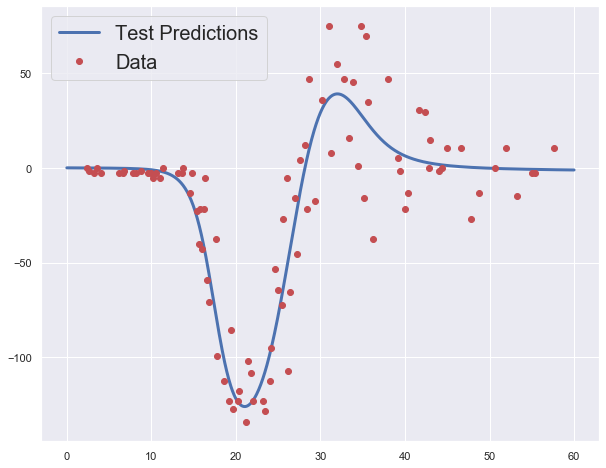

In [60]:
Xtest = torch.Tensor(xscaler.transform(np.linspace(0., 60., 1000)[:, None]))
Ypred = net(Xtest)

plt.figure( figsize=(10, 8) )
plt.plot(xscaler.inverse_transform(Xtest.data.numpy()), 
         yscaler.inverse_transform(Ypred.data.numpy()),
         linewidth=3,
         label='Test Predictions')
plt.plot(X, Y, 'ro', label='Data')
plt.legend(loc='best', fontsize=20)

## Non-exhaustive list of topics not covered here:

1. Regularizing a neural network with techniques such as dropout (`nn.Dropout`), batch normalization (`nn.BatchNorm1D`, `nn.BatchNorm2D`, `nn.BatchNorm3D`).

2. Weight Initialization (uniform, normal, [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), [He initialization](https://arxiv.org/pdf/1502.01852.pdf) etc.) All common initialization techniques can be found under `nn.init` ([see here](https://pytorch.org/docs/stable/nn.init.html#nn-init-doc)).

3. Learning rate (or step size) schedule (Step schedule, exponential schedule, cosine annealing etc.) ([look for the section on how to adjust learning rate here](https://pytorch.org/docs/stable/optim.html)).

4. Hyperparameter optimization (grid search, cross-validation, Bayesian optimization etc.)

5. Model averaging. 

6. Stochastic weight averaging - https://arxiv.org/abs/1803.05407. This feature is available in `PyTorch`; [see here](https://pytorch.org/blog/stochastic-weight-averaging-in-pytorch/?utm_source=social-facebook&utm_medium=PyTorch&utm_campaign=organic&utm_content=post-url&utm_offering=artificial-intelligence&utm_product=AIStochasticWeight_050819&fbclid=IwAR28pSPYvd-9Qlx2nOvZF7c965TcnvNQENytm1HKQy1vKLHNifEZRzp5S8s).

## Bayesian Neural Network 

Starting with a prior $p(\theta)$ on the DNN weights and biases and a likelihood model $p(\mathcal{D} | \theta)$, we wish to approximate the posterior distribution over the DNN weights and biases $p(\theta | \mathcal{D})$. 

To efficiently implement and train a Bayesian Neural Network, we will use the `pyro` probabilistic programming library which is written on top of `PyTorch`. 

In [130]:
import pyro
import pyro.distributions as dist 
from pyro import infer
from pyro import optim 
from pyro.contrib import autoguide
from pyro.nn import PyroSample, PyroModule

In [157]:
class BayesianNeuralNetwork( PyroModule ):
    def __init__(self, layersizes=[1, 1], activation = torch.tanh,
                 final_layer_activation = None, 
                 prior_scale = 0.1, 
                 sigma = 0.1):
        """
        INPUTS:
            layersizes <list/tuple>: An iterable ordered object containing
                                 the sizes of the tensors from the
                                 input layer to the final output. 
                                 (See example below). 
            activation <callable>: A python callable through which
                                    torch backpropagation is possible.
            final_layer_activation <callable>: A python callable for 
                                    the final layer activation function.
                                    Default: None (for regression problems)
            prior_scale <float>: The prior standard deviation over the weights. 
            sigma <float>: The likelihood noise standard deviation
        """
        super(BayesianNeuralNetwork, self).__init__()
        self.prior_scale = prior_scale
        self.sigma       = sigma
        self.layersizes = layersizes
        self.input_dim = self.layersizes[0]
        self.hidden_sizes = self.layersizes[1:-1]
        self.output_dim = self.layersizes[-1]
        self.activation = activation
        self.final_layer_activation = final_layer_activation
        if self.final_layer_activation is None:
            self.final_layer_activation = nn.Identity()
        self.nlayers = len(self.hidden_sizes) + 1
        self.layernames = [] 
        
        # define FC layers
        # to treat the parameters of the network as latent variables
        # place priors over them using PyroSample 
        for i in range(self.nlayers):
            layername = 'fc_{}'.format(i+1)
            self.layernames.append(layername)
            layer = PyroModule[nn.Linear](self.layersizes[i], self.layersizes[i+1])
            weightprior = dist.Normal(0., prior_scale).expand(layer.weight.shape).to_event(2)
            biasprior = dist.Normal(0., prior_scale).expand(layer.bias.shape).to_event(1)
            layer.weight = PyroSample(weightprior)
            layer.bias = PyroSample(biasprior)
            setattr(self, layername, layer)
        
    def forward(self, x, y=None):
        """
        Specify the generative process here. 
        
        INPUTS:
            x -> Input features on which to condition the observations. 
            y -> Observed data. 
            
        RETURNS:
            loc -> Predictive mean.
        """
        ysigma = self.sigma 
        
        # get the mean 
        ymean = x
        for i, layername in enumerate(self.layernames):
            fclayer = getattr(self, layername)
            ymean = fclayer(ymean)
            if i == self.nlayers - 1:
                ymean = self.final_layer_activation( ymean )
            else:
                ymean = self.activation( ymean )
        ymean = ymean[:,0]
                
        # pyro.plate will take care of mini batch scaling 
        with pyro.plate('data', x.shape[0]):
            y = pyro.sample('y', dist.Normal(ymean, ysigma), obs=y)
        
        return ymean

In [158]:
# instantiate the Bayesian Neural network 
prior_scale = 1.
sigma = 1e-1
bnn = BayesianNeuralNetwork(layersizes=[1, 200, 1], 
                            prior_scale=prior_scale,
                            sigma=1e-1)   # this will be the pyro `model` 

`pyro` has several choices for the variational posterior:

In [159]:
[name for name in dir(infer.autoguide) if 'Auto' in name]

['AutoCallable',
 'AutoContinuous',
 'AutoDelta',
 'AutoDiagonalNormal',
 'AutoDiscreteParallel',
 'AutoGuide',
 'AutoGuideList',
 'AutoIAFNormal',
 'AutoLaplaceApproximation',
 'AutoLowRankMultivariateNormal',
 'AutoMultivariateNormal',
 'AutoNormal',
 'AutoNormalizingFlow']

In [160]:
# training validation splot and preprocessing 
Ntrain = int(0.7*N)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, train_size=Ntrain)

# scale the data
xscaler = StandardScaler()
yscaler = StandardScaler()
Xtrain=xscaler.fit_transform(Xtrain)
Ytrain=yscaler.fit_transform(Ytrain)
Xval, Yval = xscaler.transform(Xval), yscaler.transform(Yval)

In [161]:
# instantiate the variational posterior 
q_bnn = infer.autoguide.AutoDiagonalNormal( bnn )

# always clear the parameter store before inference
pyro.clear_param_store()  

# define a loss function 
loss = infer.trace_elbo.Trace_ELBO(num_particles=5)

# define an optimizer 
optim_dict = {'lr':1e-2}  # dictionary of optimizer settings
optimizer = pyro.optim.Adam(optim_dict)

# instantiate the inference engine 
svi = infer.SVI(model=bnn, 
                guide=q_bnn, 
                optim=optimizer, 
                loss=loss)

### TRAINING LOOP ###
niters = 5000
losses = []
Xtrain, Ytrain = torch.Tensor(Xtrain), torch.Tensor(Ytrain)
Xval, Yval = torch.Tensor(Xval), torch.Tensor(Yval)
data = torch.Tensor(Y)
for i in tqdm_notebook(range(niters)):
    loss = svi.step(Xtrain, Ytrain[:,0])
    losses.append(loss)

/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Let's check the ELBO.

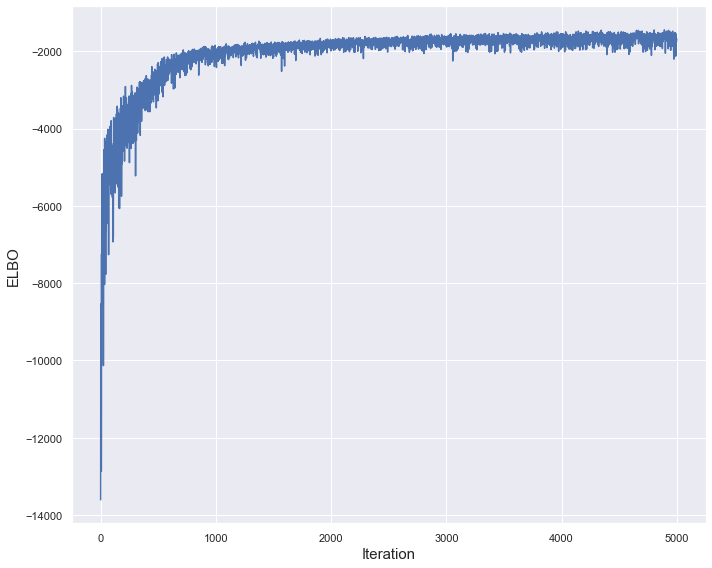

In [162]:
plt.figure(figsize=(10, 8))
losses = np.array(losses)
plt.plot(np.arange(1, niters+1), -losses)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.tight_layout()

Now let's get the posterior predictive samples. 

In [167]:
Xtest = torch.Tensor(xscaler.transform(np.linspace(0., 60., 500)[:, None]))
predictor = infer.Predictive(model=bnn, 
                             guide=q_bnn, 
                             num_samples=1000, 
                             return_sites=("y", "_RETURN"))
ppsamples = predictor(Xtest)

In [168]:
ppmean = ppsamples["_RETURN"].data.numpy().mean(0)
ppmean = yscaler.inverse_transform(ppmean)
pplow, pphigh = np.percentile(ppsamples["_RETURN"].data.numpy(), axis=0, q=[2.5, 97.5])
pplow = yscaler.inverse_transform(pplow)
pphigh = yscaler.inverse_transform(pphigh)

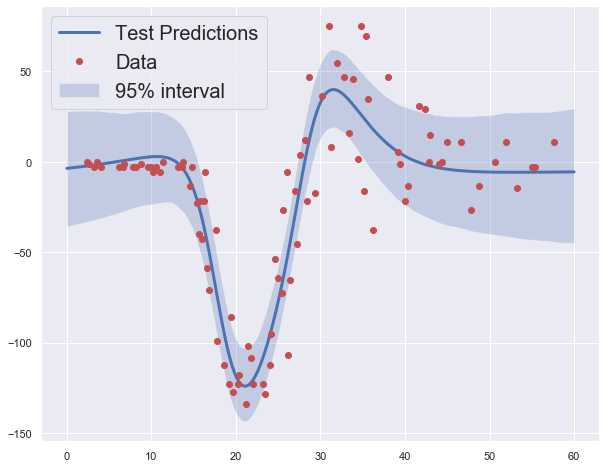

In [169]:
plt.figure( figsize=(10, 8) )
Xtest=xscaler.inverse_transform(Xtest.data.numpy())
plt.plot(Xtest, 
         ppmean,
         linewidth=3,
         label='Test Predictions')
plt.fill_between(Xtest[:,0], pplow, pphigh, alpha=0.25, label='95% interval')
plt.plot(X, Y, 'ro', label='Data')

plt.legend(loc='best', fontsize=20)

## Computational challenges of training BNNs

Training DNNs in a truly Bayesian way is challenging for a number of reasons:

1. Since the likelihood mean is nonlinear, the model evidence is intractable in closed form - we cannot leverage conjugacy. 

2. A DNN is typically highly overparameterized. This means we have to perform approximate inference in a very high-dimensional space; there is a non-trivial space cost in addition to time cost for Bayesian training of DNNs. For example, say a DNN has $N$ weights and biases in total. 

    (i) The performance of Metropolis-Hastings degrades rapidly with the number of parameters, requiring tens of thousands (or more) simulations to reach equilibrium. In practice, one often finds that classical MH samplers simply do not converge. If the sampler does converge, and say after burning and thinning you retain 1000 samples from the MCMC trace, you need to store $1000N$ floating point numbers in memory to compute posterior expectations.
    
    (ii) The HMC/NUTS approach to inference is based on simulating a hypothetical Hamiltonian system where the vector of latent variables $\theta$ are augmented with a vector of momentum variables $\mathbf{r}$ of the same size. At any given iteration of HMC/NUTS you work with $2N$ variables in memory. 
    
    (iii) The most cost efficient Variational Inference approximation is a mean field Gaussian $p(\theta | \mathcal{D}) \approx q(\theta) = \prod_{i=1}^{N} q(\theta_i)$, where, $q(\theta_i) = \mathcal{N}(\theta_i | \mu_i, \sigma_i^2)$. Using this variational approximation you will capture one of the modes of the posterior and none of the correlation across parameters. To be able to compute expectations afterwards, you need to be able to store $2N$ parameters in memory (all the $\mu_i$s and $\sigma_i$s). 
    
    (iv) A full-rank Gaussian variational posterior has memory requirements of $\mathcal{O}(N + N^2)$ - which, for reasonably large DNNs, is not feasible. 
    
    (v) A compromise variational approximation between the mean field Gaussian and the full rank Gaussian is to use a Gaussian whose covariance matrix is a diagonal with a low-rank update. Such a variational posterior has memory requirements of $\mathcal{O}((2+r)N)$, where, $r$ is the rank of the update.
    
    (vi) VI, of any kind, is prone to getting trapped in a bad local minima of the negative ELBO. 

## Physics-informed Deep Neural Networks 


Because DNNs afford a great deal of flexibility in their structure and training methodology, they find use in many non-traditional machine learning tasks. A recently emergent area of research in scientific machine learning is the application of DNNs to the task of partial differential equations (PDEs) (see the references). 

The idea is simple. Say we have a PDE of the form:
$$
\frac{\partial u}{\partial t} + \mathcal{N}\left[u, \frac{\partial u}{\partial x}, \dots \right]=0, \ \forall \mathbf{x} \in \Omega, \ t \in [0, T],
$$

subject to initial conditions $u(\mathbf{x}, 0) = g(\mathbf{x})$ and boundary conditions $u(\mathbf{x}, t) = h(\mathbf{x}, t)$. 

We start with a DNN trial solution, $u(x, t) = \varphi(x, t; \theta)$, where, $\theta$ represents all the tunable parameters of the network. Suppose we sample a bunch of collocation points inside the PDE domain $\{ \mathbf{x}^{(i)} \}_i \subset \Omega$ and a bunch of collocation points $\{t^{(i)}\}_i \in (0, T]$. For $\varphi$ to accurate represent the solution, the LHS of the PDE, evaluated at these collocation points, must be 0. We can therefore formulate a loss function of the form:
$$
\mathcal{R}_{\Omega} = \frac{1}{N_{\Omega}} \sum_{i}\left( \frac{\partial u}{\partial t}\Big|_{x=x^{(i)}, t=t^{(i)}} + \mathcal{N}\left[u, \frac{\partial u}{\partial x}, \dots \right]\Big|_{x=x^{(i)}, t=t^{(i)}} \right)^2,
$$
where, $N_{\Omega}$ is the number of collocation points.  This is the squared residual of the PDE at the collocation points. 

We can similarly take a set of collocation points in space and time, sampled arbitrarily, and formulate a boundary residual:
$$
\mathcal{R}_{\partial \Omega} =\frac{1}{N_{\partial\Omega}} \sum_{i} h(\mathbf{x}, t)^2\Big|_{x=x^{(i)}, t=t^{(i)}},
$$
where, $N_{\partial\Omega}$ is the number of boundary collocation points. Similarly, the initial conditions residual will be:
$$
\mathcal{R}_{t} =\frac{1}{N_{t}} \sum_{i} g(\mathbf{x})^2\Big|_{x=x^{(i)}}.
$$

We can take all the derivatives necessary to construct these residuals for free using automatic differentiation (`torch.autograd.grad` in `PyTorch`). All of these residual terms individually are functions of the parameters $\theta$ of the DNN $\varphi$ and we can compose a total residual loss function by adding them up:
$$
\mathcal{R}(\theta) = \mathcal{R}_{ \Omega}(\theta) + \mathcal{R}_{\partial \Omega}(\theta) + \mathcal{R}_{t}(\theta).
$$

Now all we have to do is to use SGD to solve the optimization problem:
$$
\theta^* = \underset{\theta}{\mathrm{argmin}}\mathcal{R}(\theta).
$$

Below we demonstrate this idea by applying it to the Burgers' equation in 1D. 

### Burgers' Equation in 1D

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \frac{0.01}{\pi} \frac{\partial^2 u}{\partial x}, \ x \in [-1, 1],\ t \in [0, 1],
$$

subject to initial conditions:
$$
u(0, x) = -\sin \pi x, 
$$
and periodic boundary conditions:
$$
u(t, -1) = u(t, 1).
$$

In [243]:
def sqresidual(net, x, t):
    assert x.requires_grad == True and t.requires_grad == True
    X = torch.stack([x, t], 1).squeeze(-1)
    u = net(X)
    ux = grad(u, x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(u))[0]
    ut = grad(u, t, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(u))[0]
    uxx = grad(ux, x, retain_graph=True, create_graph=True, grad_outputs=torch.ones_like(ux))[0]
    residual = ut + u*ux - (0.01/np.pi)*uxx
    return torch.norm(residual)**2

def boundaryresidual(net, t):
    leftx = -torch.ones_like(t, requires_grad=True)
    leftX = torch.stack([leftx, t], 1).squeeze(-1)
    
    rightx = torch.ones_like(t, requires_grad=True)
    rightX = torch.stack([leftx, t], 1).squeeze(-1)
    
    leftU = net(leftX)
    rightU = net(rightX)
    boundary_res = torch.norm(leftU-rightU)**2
    
    return boundary_res
    
    
def initialcond_residual(net, x):
    initt = torch.zeros_like(x, requires_grad=True)
    initX = torch.stack([x, initt], 1).squeeze(-1)
    
    initU = net(initX)
    init_res = torch.norm(initU + torch.sin(np.pi*x))**2
    return init_res

def L2loss(lmbda, net):
    reg = torch.tensor(0.)
    for m in net.modules():
        if hasattr(m, 'weight'):
            reg += m.weight.norm()**2
    return lmbda*reg

In [251]:
## define a network to approximate the PDE solution 
layersizes = [2] + [20]*9 + [1]  
pinn = NeuralNetwork(layersizes=layersizes, activation=torch.sin)

### define an optimizer 
lr = 1e-3
update = torch.optim.Adam(params=pinn.parameters(), lr=lr)

# training loop params 
maxiter = 5000
batchsize = 500
lmbda = 1e-5
best_stat_dict = pinn.state_dict()
best_val_loss = np.inf
tval = torch.rand((200,1), requires_grad=True)
xval = -1. + 2*torch.rand((200,1), requires_grad=True)

## training loop 
for i in range(maxiter):
    # sample a batch of data 
    tbatch = torch.rand((batchsize,1), requires_grad=True)
    xbatch = -1. + 2*torch.rand((batchsize,1), requires_grad=True)
    
    # zero out the gradient buffers
    update.zero_grad()
    
    # compute the regularized loss 
    loss = sqresidual(pinn, xbatch, tbatch) +\
           boundaryresidual(pinn, tbatch) +\
           initialcond_residual(pinn, xbatch) #+ L2loss(lmbda, pinn)
    
    # back prop to get gradients 
    loss.backward()
    
    # take one optimization step
    update.step()
    
    # print progress 
    if (i+1)%100 == 0:
        val_loss = sqresidual(pinn, xval, tval)
        print(' [Iteration %4d] Validation Squared Residual: %.5f'%(i+1, val_loss))
        if val_loss < best_val_loss:
            best_state_dict = pinn.state_dict()
pinn.load_state_dict(best_stat_dict);

 [Iteration  100] Validation Squared Residual: 10.17115
 [Iteration  200] Validation Squared Residual: 8.47603
 [Iteration  300] Validation Squared Residual: 8.76725
 [Iteration  400] Validation Squared Residual: 8.79585
 [Iteration  500] Validation Squared Residual: 8.08372
 [Iteration  600] Validation Squared Residual: 9.79117
 [Iteration  700] Validation Squared Residual: 9.11616
 [Iteration  800] Validation Squared Residual: 6.07924
 [Iteration  900] Validation Squared Residual: 5.83025
 [Iteration 1000] Validation Squared Residual: 2.69280
 [Iteration 1100] Validation Squared Residual: 5.42795
 [Iteration 1200] Validation Squared Residual: 3.44732
 [Iteration 1300] Validation Squared Residual: 2.85521
 [Iteration 1400] Validation Squared Residual: 1.63377
 [Iteration 1500] Validation Squared Residual: 3.23787
 [Iteration 1600] Validation Squared Residual: 1.30064
 [Iteration 1700] Validation Squared Residual: 2.87915
 [Iteration 1800] Validation Squared Residual: 2.02666
 [Iterati

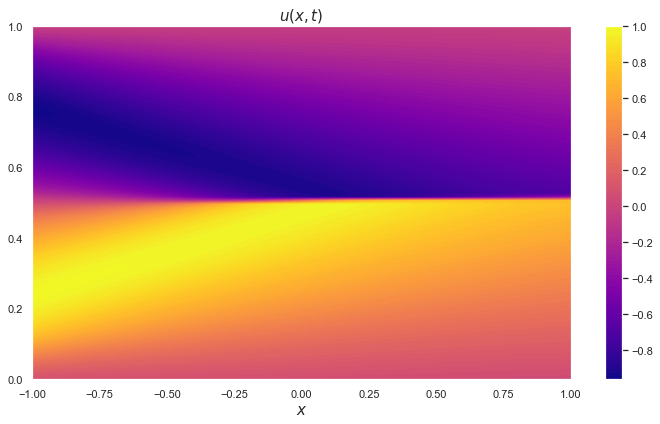

In [262]:
xtest = torch.linspace(-1., 1, 100)
ttest = torch.linspace(0., 1, 100)
Xtest1, Xtest2 = torch.meshgrid(xtest, ttest)
Xtest = torch.stack([Xtest1.flatten(), Xtest2.flatten()], 1).squeeze(-1)
Upred = pinn(Xtest).view(100, 100)

plt.figure(figsize=(10, 6))
plt.contourf(Xtest1.data.numpy(), Xtest2.data.numpy(), Upred.data.numpy().T, 100, cmap='plasma')
plt.title('$u(x, t)$', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.xlabel('$x$', fontsize=15)
plt.colorbar()
plt.tight_layout();